In [161]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from functools import partial
import pandas as pd

# 1. Simulation of Fernando's original model

In [162]:
#Params includes alpha, beta, theta, phi, lam, m in the final model

def model1(t, vars, params):
    alpha, beta, theta, phi, lam, m = params
    C_A2, C_S = vars
    dC_A2dt = 1 - alpha * C_A2 * C_S**m - theta * C_A2
    dC_Sdt = alpha/lam * C_A2 * C_S**m - beta * C_S**(m + 1) + theta/lam * C_A2 - phi * C_S
    return (dC_A2dt, dC_Sdt)

$$
\frac{d C_{A_2}}{dt} = 1- \alpha C_{A_2}C_S^m - \theta C_{A_2}  
\\
\frac{d C_s}{dt} = \frac{\alpha}{\lambda}C_{A_2}C_S^m - \beta C_s^{m+1} + \frac{\theta}{\lambda} C_{A_2} - \phi C_s
$$

## 1.1 One oscillatory parameters set

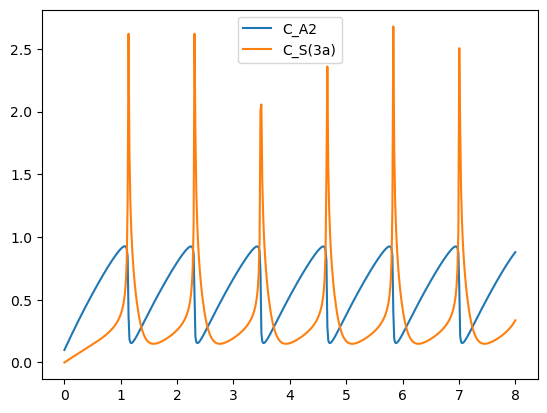

In [163]:
#Simulation of 'blind' parameters
alpha = 5
beta = 8

theta = 0.3
phi = 10

lam = 0.1
m = 3

params = [alpha, beta, theta, phi, lam, m]
model1_partial = partial(model1, params = params)

init_cond = (0.1,0) #C_A2 = 0.1, C_S = 0
t_span = (0, 8)
t_eval = np.linspace(0, 8, 500)

solution1 = solve_ivp(model1_partial, t_span = t_span, y0 = init_cond, t_eval = t_eval, rtol=1e-6, atol=1e-8)

plt.plot(solution1.t, solution1.y[0], label = 'C_A2')
plt.plot(solution1.t, solution1.y[1], label = 'C_S(3a)')
plt.legend()

## 1.2 Optimization of parameters

Var names:

ExpA: Nat. Chem. 2022, SI figure 18 (S = 3a)

ExpB: Nat. Chem. 2022, Fig 1f (S = 3b)

### 1.2.1 Oscillation of 3a

In [164]:
df_exp = pd.read_csv(r'C:\Users\chem-sedm6967\OneDrive - Nexus365\Desktop\01_projects\01_oscillation modelling\Chemical_Oscillation_Model\Data_sets\3a_expA_osc_NatChem_MH.csv')

CMC = 1.56

#Non-dimentionalized data
t_expA = np.array(df_exp['Time'])
C3a_expA = np.array(df_exp['C3a']) / CMC

Text(0, 0.5, 'Non-dimensional Conc (Surf 3a)')

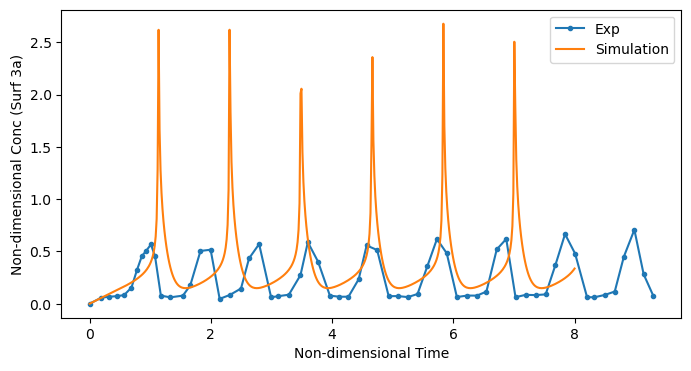

In [165]:
fig, ax = plt.subplots(1, 1, figsize = (8,4))
ax.plot(t_expA, C3a_expA, marker = '.', label = 'Exp')
ax.plot(solution1.t, solution1.y[1], label = 'Simulation')
ax.legend()
ax.set_xlabel('Non-dimensional Time')
ax.set_ylabel('Non-dimensional Conc (Surf 3a)')

In [166]:
def model1_4params(t, vars, params, lam, m):
    alpha, beta, theta, phi= params
    C_A2, C_S = vars
    
    dC_A2dt = 1 - alpha * C_A2 * C_S**m - theta * C_A2
    dC_Sdt = alpha/lam * C_A2 * C_S**m - beta * C_S**(m + 1) + theta/lam * C_A2 - phi * C_S
    
    return (dC_A2dt, dC_Sdt)

def simulate(params, t_exp, lam, m, init_cA2):
    model1_4params_partial = partial(model1_4params, params = params, lam = lam, m = m)
    
    init_cond = [init_cA2, 0]
    t_span = [t_exp[0], t_exp[-1]]

    sol = solve_ivp(model1_4params_partial, t_span=t_span, t_eval=t_exp, y0=init_cond, rtol=1e-6, atol=1e-8)
    return sol.y

#2 versions of objective functions are defined. The first one is for the case where only surfactant concentration is measured. 
#The second one is for the case where two concentrations (disulfide and surfactant) are measured.

def objective(params, t_exp, Cs_exp, lam, m, init_cA2 = 0.1):
    sim = simulate(params, t_exp, lam, m, init_cA2)
    print(params)
    Cs_sum = sim[1] + (sim[1]) ** m
    return np.sum((Cs_sum-Cs_exp)**2)

def objective_2conc(params, tA2_exp, tS_exp, CA2_exp, Cs_exp, lam, m, init_cA2 = 0.1):
    simA2 = simulate(params, tA2_exp, lam, m, init_cA2)
    simS = simulate(params, tS_exp, lam, m, init_cA2)
    print(params)
    Cs_sum = simS[1] + (simS[1]) ** m
    CA2 = simA2[0]
    return np.sum((Cs_sum-Cs_exp)**2 + (CA2 - CA2_exp)**2)

In [167]:
def calculate_other_conc(sol, m, lam):
    C_A2 = sol.y[0]
    C_S = sol.y[1]
    C_M = C_S ** m
    C_A = 2 * (1 - C_A2) - lam * (C_S + C_M)
    return (C_A2, C_S, C_M, C_A)

### 1.2.2 Oscillation of 3b

In [168]:
df_expB_3b = pd.read_csv(r'C:\Users\chem-sedm6967\OneDrive - Nexus365\Desktop\01_projects\01_oscillation modelling\Chemical_Oscillation_Model\Data_sets\3b_expB_osc_NatChem_MH.csv')
df_expB_1 = pd.read_csv(r'C:\Users\chem-sedm6967\OneDrive - Nexus365\Desktop\01_projects\01_oscillation modelling\Chemical_Oscillation_Model\Data_sets\1_expB_osc_NatChem_MH.csv')
df_expB_4 = pd.read_csv(r'C:\Users\chem-sedm6967\OneDrive - Nexus365\Desktop\01_projects\01_oscillation modelling\Chemical_Oscillation_Model\Data_sets\4_expB_osc_NatChem_MH.csv')

In [169]:
df_expB = pd.concat([df_expB_3b, df_expB_1, df_expB_4], axis=1)
df_expB.columns = ['Time3b', '3b', 'Time1', '1', 'Time4', '4']

In [170]:
df_expB = df_expB.clip(lower=0)

In [171]:
df_expB = df_expB.drop_duplicates(subset=['Time3b'])
df_expB = df_expB.drop_duplicates(subset=['Time1'])
df_expB = df_expB.drop_duplicates(subset=['Time4'])

In [172]:
df_expB

,Time3b,3b,Time1,1,Time4,4
0,0.021505,0.00,0.000000,0.043651,0.064343,6.198020
1,0.086022,0.10,0.053763,0.063492,0.128686,6.039604
3,0.161290,0.40,0.129032,0.051587,0.225201,6.039604
4,0.172043,0.40,0.215054,0.039683,0.246649,6.356436
6,0.247312,0.12,0.286239,0.000000,0.300268,6.316832
...,...,...,...,...,...,...
153,7.634409,0.12,7.537634,0.003968,7.581769,5.881188
154,7.709677,0.26,7.645161,0.003968,7.689008,5.762376
155,7.752688,0.42,7.731183,0.023810,7.742627,5.564356
156,7.774194,0.40,7.752688,0.059524,7.796247,5.168317


Initial Guess

<Axes: >

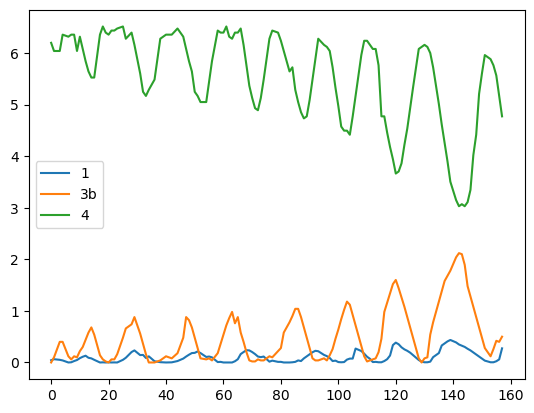

In [173]:
df_expB[['1','3b','4']].plot()

In [174]:
cut_off = 95
CMC_3b = 0.52

t3b_expB = np.array(df_expB['Time3b'][0:cut_off])
tA2_expB = np.array(df_expB['Time1'][0:cut_off])
tA_expB = np.array(df_expB['Time4'][0:cut_off])

C_A2tol = df_expB['1'][0] + 1/2 * df_expB['4'][0]

C3b_expB = np.array(df_expB['3b'][0:cut_off])/CMC_3b
CA2_expB = np.array(df_expB['1'][0:cut_off])/C_A2tol
CA_expB = np.array(df_expB['4'][0:cut_off])/C_A2tol

Optimization

In [175]:
#Initial Guess
alpha = 12
beta = 3

theta = 3
phi = 12

#Fixed parameters
lam = 0.17
m = 4

init_cA2 = 0.1

params = [alpha, beta, theta, phi]

#result_expB = sp.optimize.minimize(objective_2conc, params, args=(tA2_expB, t3b_expB, CA2_expB, C3b_expB, lam, m), method='Nelder-Mead',options={'disp': True, 'maxfev': 100000})

#print(result_expB.x)

[24.30616411  1.1391591   3.08829181 10.66927823] m = 4, lam = 0.17

Text(0, 0.5, 'Non-dimensional Conc (Surf 3b)')

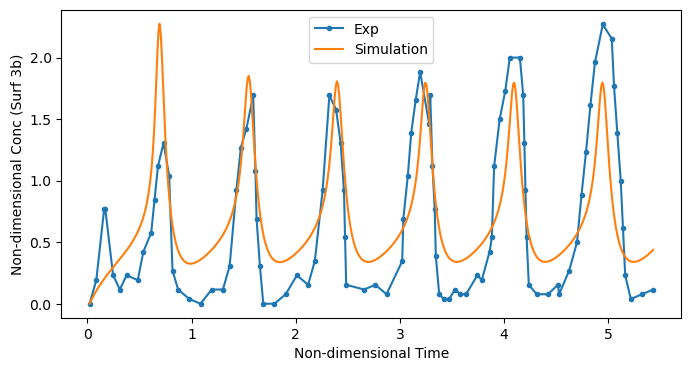

In [176]:
params = [24.30616411, 1.1391591, 3.08829181, 10.66927823]
model1_4params_partial = partial(model1_4params, params = params, lam = lam, m = m)
init_cond = [init_cA2, 0]
t_span = [t3b_expB[0], t3b_expB[-1]]
t_eval = np.linspace(t3b_expB[0], t3b_expB[-1], 500)

sol = solve_ivp(model1_4params_partial, t_span=t_span, t_eval=t_eval, y0=init_cond, rtol=1e-6, atol=1e-8)

fig, ax = plt.subplots(1, 1, figsize = (8,4))
ax.plot(t3b_expB, C3b_expB, marker = '.', label = 'Exp')
ax.plot(sol.t, sol.y[1] + sol.y[1] ** m, label = 'Simulation')
ax.legend()
ax.set_xlabel('Non-dimensional Time')
ax.set_ylabel('Non-dimensional Conc (Surf 3b)')

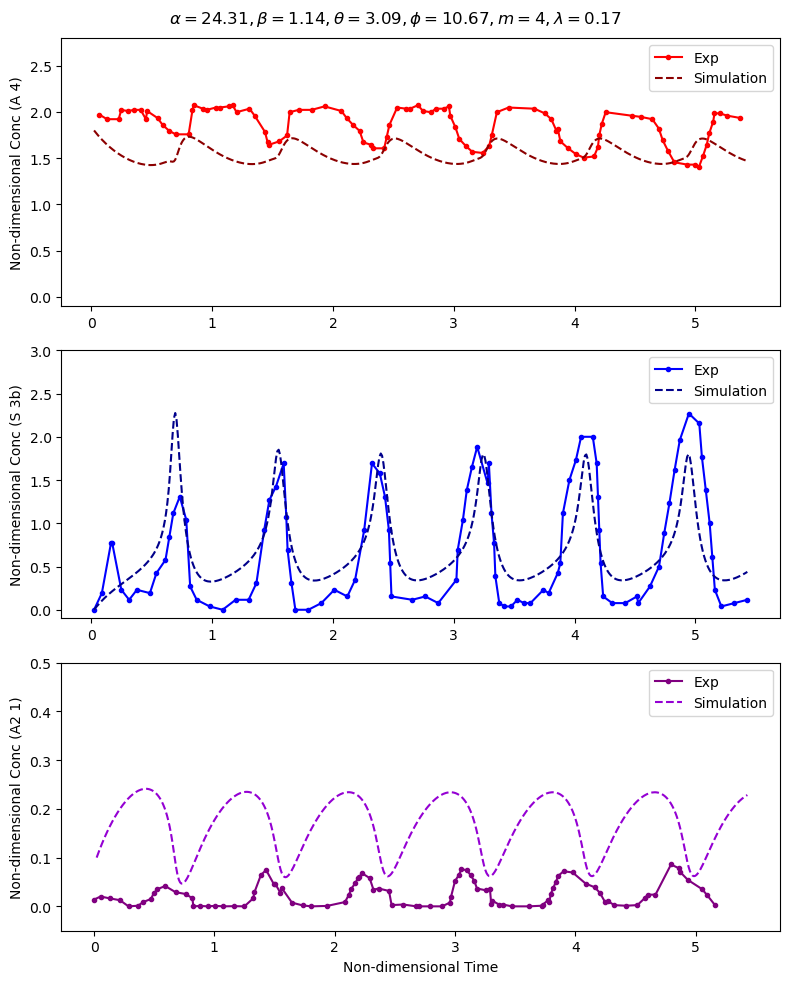

In [178]:
CA2_3b, CS_3b, CM_3b, CA_3b = calculate_other_conc(sol, m = m, lam=lam)

fig, ax = plt.subplots(3, 1, figsize = (8,10))
fig.suptitle(r'$\alpha = 24.31, \beta = 1.14, \theta = 3.09, \phi = 10.67, m = 4, \lambda = 0.17$')
ax[0].plot(tA_expB, CA_expB, marker = '.', label = 'Exp', color = 'red')
ax[0].plot(sol.t, CA_3b, label = 'Simulation', color = 'darkred', linestyle = '--')
ax[0].legend(loc='upper right')
ax[0].set_ylim(-0.1, 2.8)
ax[1].plot(t3b_expB, C3b_expB, marker = '.', label = 'Exp', color = 'blue')
ax[1].plot(sol.t, CS_3b + CM_3b, label = 'Simulation', color = 'darkblue', linestyle = '--')
ax[1].legend(loc='upper right')
ax[1].set_ylim(-0.1, 3)
ax[2].plot(tA2_expB, CA2_expB, marker = '.', label = 'Exp', color = 'purple')
ax[2].plot(sol.t, CA2_3b, label = 'Simulation', color = 'darkviolet', linestyle = '--')
ax[2].legend(loc='upper right')
ax[2].set_ylim(-0.05, 0.5)
ax[2].set_xlabel('Non-dimensional Time')
ax[0].set_ylabel('Non-dimensional Conc (A 4)')
ax[1].set_ylabel('Non-dimensional Conc (S 3b)')
ax[2].set_ylabel('Non-dimensional Conc (A2 1)')
fig.tight_layout()

In [ ]:
params = np.array([24.30616411, 1.1391591, 3.08829181, 10.66927823])

lam = 0.17
m = 4
init_cA2 = 0.1

scale = [0.95, 1, 1.2, 1.5]
sols = []
for s in scale:
    params_new = params / s
    model1_4params_partial = partial(model1_4params, params = params_new, lam = lam, m = m)
    init_cond = [init_cA2, 0]
    t_span = [t3b_expB[0], t3b_expB[-1]]
    t_eval = np.linspace(t3b_expB[0], t3b_expB[-1], 500)

    sol = solve_ivp(model1_4params_partial, t_span=t_span, t_eval=t_eval, y0=init_cond, rtol=1e-6, atol=1e-8)
    sols.append(sol)

Text(0.5, 0, 'Non-dimensional Time')

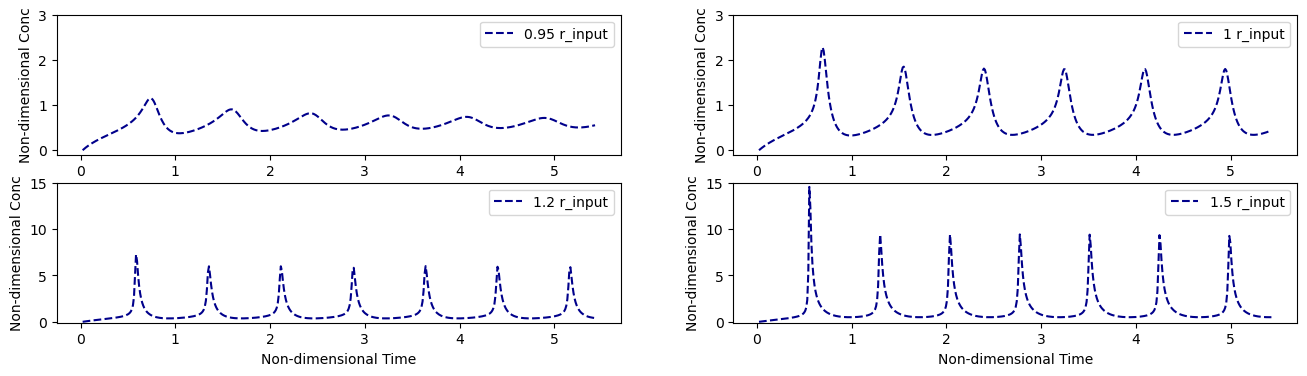

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (16,4))
for ax, sol, s in zip(axes.flatten(), sols, scale):
    ax.plot(sol.t, sol.y[1] + sol.y[1] ** m, label = f'{s} r_input', color = 'darkblue', linestyle = '--')
    ax.legend(loc='upper right')
    ax.set_ylim(-0.1, 15)
    ax.set_ylabel('Non-dimensional Conc')

axes[0][0].set_ylim(-0.1, 3)
axes[0][1].set_ylim(-0.1, 3)
axes[1][0].set_xlabel('Non-dimensional Time')
axes[1][1].set_xlabel('Non-dimensional Time')

(-0.1, 4.0)

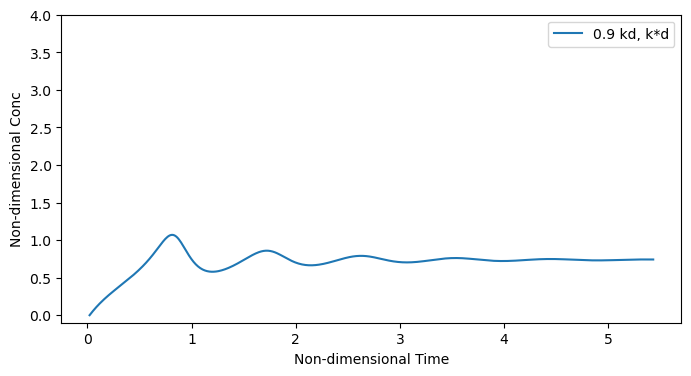

In [ ]:
scale = 0.9

beta = 1.139 * scale

theta = 3.088 

phi = 10.669 * scale

params = np.array([alpha, beta, theta, phi])

model1_4params_partial = partial(model1_4params, params = params, lam = lam, m = m)
init_cond = [init_cA2, 0]
t_span = [t3b_expB[0], t3b_expB[-1]]
t_eval = np.linspace(t3b_expB[0], t3b_expB[-1], 500)

sol = solve_ivp(model1_4params_partial, t_span=t_span, t_eval=t_eval, y0=init_cond, rtol=1e-6, atol=1e-8)

fig, ax = plt.subplots(1, 1, figsize = (8,4))
ax.plot(sol.t, sol.y[1] + sol.y[1] ** m, label = f'{scale} kd, k*d')
ax.legend()
ax.set_xlabel('Non-dimensional Time')
ax.set_ylabel('Non-dimensional Conc')
ax.set_ylim(-0.1, 4)

(-0.1, 4.0)

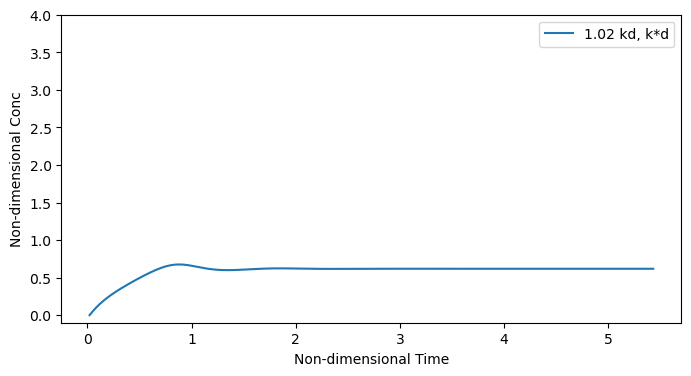

In [ ]:
scale = 1.02

beta = 1.139 * scale

theta = 3.088 

phi = 10.669 * scale

params = np.array([alpha, beta, theta, phi])

model1_4params_partial = partial(model1_4params, params = params, lam = lam, m = m)
init_cond = [init_cA2, 0]
t_span = [t3b_expB[0], t3b_expB[-1]]
t_eval = np.linspace(t3b_expB[0], t3b_expB[-1], 500)

sol = solve_ivp(model1_4params_partial, t_span=t_span, t_eval=t_eval, y0=init_cond, rtol=1e-6, atol=1e-8)

fig, ax = plt.subplots(1, 1, figsize = (8,4))
ax.plot(sol.t, sol.y[1] + sol.y[1] ** m, label = f'{scale} kd, k*d')
ax.legend()
ax.set_xlabel('Non-dimensional Time')
ax.set_ylabel('Non-dimensional Conc')
ax.set_ylim(-0.1, 4)

## 1.3 Modification of the model

Use an S shaped curve for the micelle formation rate (Hill function)

In [ ]:
def Hill(x, m, K):
    #x = abs(x)
    return x**m/(K**m + x**m)

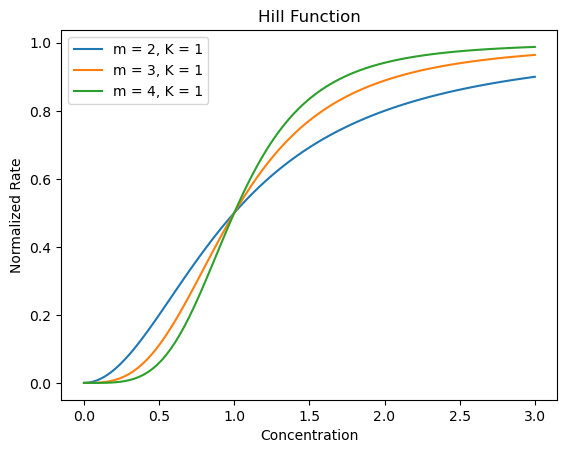

In [ ]:
m1 = 2
m2 = 3
m3 = 4
K = 1
x = np.linspace(0, 3, 100)
y1 = Hill(x, m1, K)
y2 = Hill(x, m2, K)
y3 = Hill(x, m3, K)

for m, y in [(m1, y1), (m2, y2), (m3, y3)]:
    plt.plot(x, y, label = f'm = {m}, K = {K}')

plt.xlabel('Concentration')
plt.ylabel('Normalized Rate')
plt.title('Hill Function')
plt.legend()

In [ ]:
def model_Hill(t, vars, params, cmc):
    alpha, beta, theta, phi, K, lam, m = params
    ep = Hill(cmc, m, K)
    C_A2, C_S = vars
    dC_A2dt = 1 - alpha/ep * C_A2 * Hill(C_S, m, K) - theta * C_A2
    dC_Sdt = alpha/(lam * ep) * C_A2 * Hill(C_S, m, K) - beta/ep * Hill(C_S, m, K) + theta/lam * C_A2 - phi * C_S
    return (dC_A2dt, dC_Sdt)

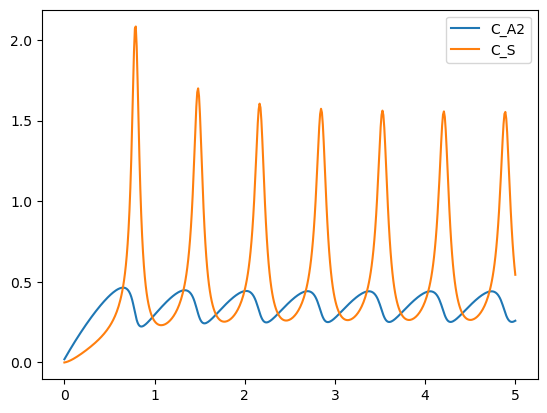

In [ ]:
init_cond = (0.02, 0) #C_A2 = 0.1, C_S = 0
t = 5
t_span = (0, t)
t_eval = np.linspace(0, t, 500)

alpha = 7.5
beta = 10
theta = 0.8
phi = 10
K = 1.5

lam = 0.17
m = 3
cmc = 0.52


params = [alpha, beta, theta, phi, K, lam, m]
model_Hill_partial = partial(model_Hill, params = params, cmc = cmc)

solution = solve_ivp(model_Hill_partial, t_span = t_span, y0 = init_cond, t_eval = t_eval, rtol=1e-6, atol=1e-8)

ep = Hill(cmc, m, K)

Cs_sum = solution.y[1] + 1/ep * Hill(solution.y[1], m, params[4])

plt.plot(solution.t, solution.y[0], label = 'C_A2')
plt.plot(solution.t, Cs_sum, label = 'C_S')
plt.legend()

In [ ]:
def model_Hill_5params(t, vars, params, lam, m, cmc):
    alpha, beta, theta, phi, K = params
    ep = Hill(cmc, m, K)
    C_A2, C_S = vars
    dC_A2dt = 1 - alpha/ep * C_A2 * Hill(C_S, m, K) - theta * C_A2
    dC_Sdt = alpha/(lam * ep) * C_A2 * Hill(C_S, m, K) - beta/ep * Hill(C_S, m, K) + theta/lam * C_A2 - phi * C_S
    return (dC_A2dt, dC_Sdt)

def simulate_Hill(params, t_exp, lam, m, cmc, init_cA2):
    model_Hill_5params_partial = partial(model_Hill_5params, params = params, lam = lam, m = m, cmc = cmc)
    init_cond = [init_cA2, 0]
    t_span = [t_exp[0], t_exp[-1]]

    sol = solve_ivp(model_Hill_5params_partial, t_span=t_span, t_eval=t_exp, y0=init_cond, rtol=1e-6, atol=1e-8)
    return sol.y

def objective_Hill(params, tA2_exp, tS_exp, CA2_exp, Cs_exp, lam, m, cmc, init_cA2 = 0.1):
    ep = Hill(cmc, m, params[4])
    simA2 = simulate_Hill(params, tA2_exp, lam, m, cmc, init_cA2)
    simS = simulate_Hill(params, tS_exp, lam, m, cmc, init_cA2)
    print(f'alpha = {params[0]:.6f}, beta = {params[1]:.6f}, theta = {params[2]:.6f}, phi = {params[3]:.6f}, K = {params[4]:.6f}')
    Cs_sum = simS[1] + 1/ep * Hill(simS[1], m, params[4])
    return np.sum((Cs_sum-Cs_exp)**2 + (simA2[0] - CA2_exp)**2)

In [ ]:
alpha = 7.5
beta = 10
theta = 0.8
phi = 12
K = 1.5

bounds = [(0.1, 20), (0.1, 50), (0.1, 50), (0.1, 50), (1, 20)]


params = [alpha, beta, theta, phi, K]

#result_Hill = sp.optimize.minimize(objective_Hill, params, args=(tA2_expB, t3b_expB, CA2_expB, C3b_expB, lam, m, cmc), method='Nelder-Mead',options={'disp': True, 'maxfev': 100000})
#result_Hill = sp.optimize.differential_evolution(objective_Hill, bounds, args=(tA2_expB, t3b_expB, CA2_expB, C3b_expB, lam, m, cmc), maxiter=1000, tol=0.01)
#print(result_Hill.x)

[10.58211573  3.61227331  0.2038565  27.33589948  0.11874392]

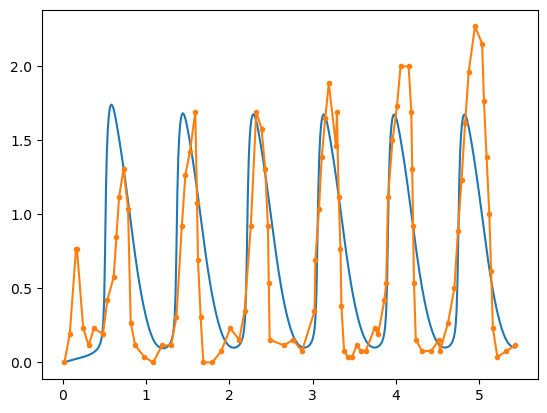

In [ ]:
params = [ 8.63641942 , 1.75602542  ,0.430039  , 20.88897184 , 0.21846561]
model_Hill_5params_partial = partial(model_Hill_5params, params = params, lam = lam, m = m, cmc = cmc)
init_cond = [init_cA2, 0]
t_span = [t3b_expB[0], t3b_expB[-1]]
t_eval = np.linspace(t3b_expB[0], t3b_expB[-1], 500)

K = params[4]
ep = Hill(cmc, m, K)

sol = sp.integrate.solve_ivp(model_Hill_5params_partial, t_span=t_span, t_eval=t_eval, y0=init_cond, rtol=1e-6, atol=1e-8)
Cs_sum = sol.y[1] + 1/ep * Hill(sol.y[1], m, params[4])

plt.plot(sol.t, Cs_sum, label = 'Simulation')
#plt.plot(sol.t, sol.y[0], label = 'Simulation')
plt.plot(t3b_expB, C3b_expB, marker = '.', label = 'Exp')
#plt.plot(tA2_expB, CA2_expB, marker = '.', label = 'Exp')

In [ ]:
def calculate_other_conc_Hill(sol, m, lam, K):
    ep = Hill(cmc, m, K)
    C_A2 = sol.y[0]
    C_S = sol.y[1]
    C_M = 1/ep * Hill(C_S, m, K)
    C_A = 2 * (1 - C_A2) - lam * (C_S + C_M)
    return (C_A2, C_S, C_M, C_A)

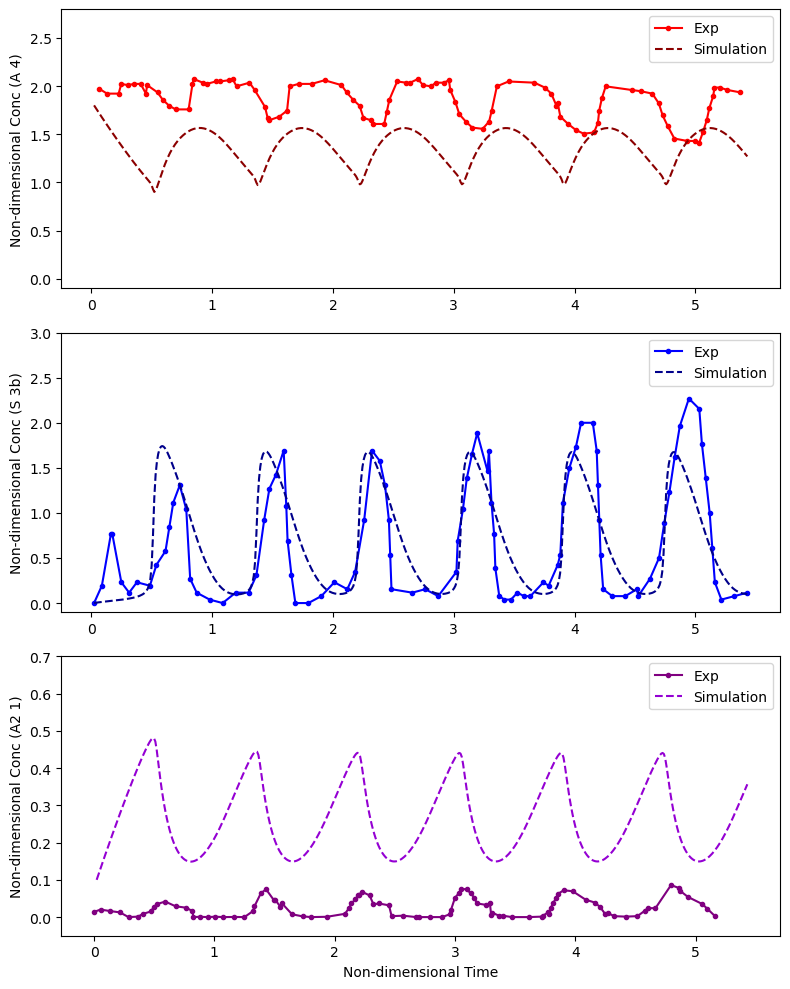

In [ ]:
C_A2, C_S, C_M, C_A = calculate_other_conc_Hill(sol, m = m, lam=lam, K = K)

fig, ax = plt.subplots(3, 1, figsize = (8,10))
#fig.suptitle(r'$\alpha = 24.31, \beta = 1.14, \theta = 3.09, \phi = 10.67, m = 4, \lambda = 0.17$')

ax[0].plot(tA_expB, CA_expB, marker = '.', label = 'Exp', color = 'red')
ax[0].plot(sol.t, C_A, label = 'Simulation', color = 'darkred', linestyle = '--')
ax[0].legend(loc='upper right')
ax[0].set_ylim(-0.1, 2.8)
ax[1].plot(t3b_expB, C3b_expB, marker = '.', label = 'Exp', color = 'blue')
ax[1].plot(sol.t, C_M + C_S, label = 'Simulation', color = 'darkblue', linestyle = '--')
ax[1].legend(loc='upper right')
ax[1].set_ylim(-0.1, 3)
ax[2].plot(tA2_expB, CA2_expB, marker = '.', label = 'Exp', color = 'purple')
ax[2].plot(sol.t, C_A2, label = 'Simulation', color = 'darkviolet', linestyle = '--')
ax[2].legend(loc='upper right')
ax[2].set_ylim(-0.05, 0.7)
ax[2].set_xlabel('Non-dimensional Time')
ax[0].set_ylabel('Non-dimensional Conc (A 4)')
ax[1].set_ylabel('Non-dimensional Conc (S 3b)')
ax[2].set_ylabel('Non-dimensional Conc (A2 1)')
fig.tight_layout()

## 1.4 Control of oscillations

In [ ]:
#calc_others(sol, consts)
class oscmodel:
    def __init__(self, model, params, consts):
        self.model = model
        self.params = params
        self.consts = consts

        self.__calc_all = None
        self.species = ['cA2', 'cS_tol', 'cA']
        self.__info = None

   
    def info(self, info):
        self.__info = info

   
    def calc_all(self, function):
        self.__calc_all = function
        
    def simulate(self, init_cond, t=10):
        params_pass = self.params + self.consts
        model_partial = partial(self.model, params = params_pass)
        t_span = (0, t)
        t_eval = np.linspace(0, t, 250)
        sol = solve_ivp(model_partial, t_span = t_span, y0 = init_cond, t_eval = t_eval, rtol=1e-6, atol=1e-8)
        return sol
    
    def plot(self, init_cond, t=10):
        sol = self.simulate(init_cond, t)
        c = self.__calc_all(sol, self.consts)
        fig, ax = plt.subplots(3, 1, figsize = (8,10))
        i = 0
        for ax, y in zip(ax, c):
            ax.plot(sol.t, y, label = self.species[i])
            ax.legend()
            i += 1
        return fig, ax
    
    def interactive_plot(self, init_cond, param_num=4, t=10, range = 10, step=0.1):
        if param_num == 4:
            print('4 parameters')
            def plot_temp(alpha, beta, theta, phi):
                params_old = self.params
                params = [alpha, beta, theta, phi]
                self.params = params
                self.plot(init_cond, t)
                self.params = params_old
            
            alpha, beta, theta, phi = self.params
            alpha_slider = widgets.FloatSlider(value=alpha, min=max(0, alpha-range), max=alpha+range, step=step, description='alpha')
            beta_slider = widgets.FloatSlider(value=beta, min=max(0, beta-range), max=beta+range, step=step, description='beta')
            theta_slider = widgets.FloatSlider(value=theta, min=max(0, theta-range), max=theta+range, step=step, description='theta')
            phi_slider = widgets.FloatSlider(value=phi, min=max(0, phi-range), max=phi+range, step=step, description='phi')

            interactive_widget = widgets.interactive(plot_temp, alpha=alpha_slider, beta=beta_slider, theta=theta_slider, phi=phi_slider)
            display(interactive_widget)

In [ ]:
params = [24.30616411, 1.1391591, 3.08829181, 10.66927823]

#Fixed parameters
lam = 0.17
m = 4
consts = [lam, m]
init_cA2 = (0.1, 0)
model_test = oscmodel(model1, params, consts)
model_test.calc_all(calculate_other_conc)

(<Figure size 800x1000 with 3 Axes>, <Axes: >)

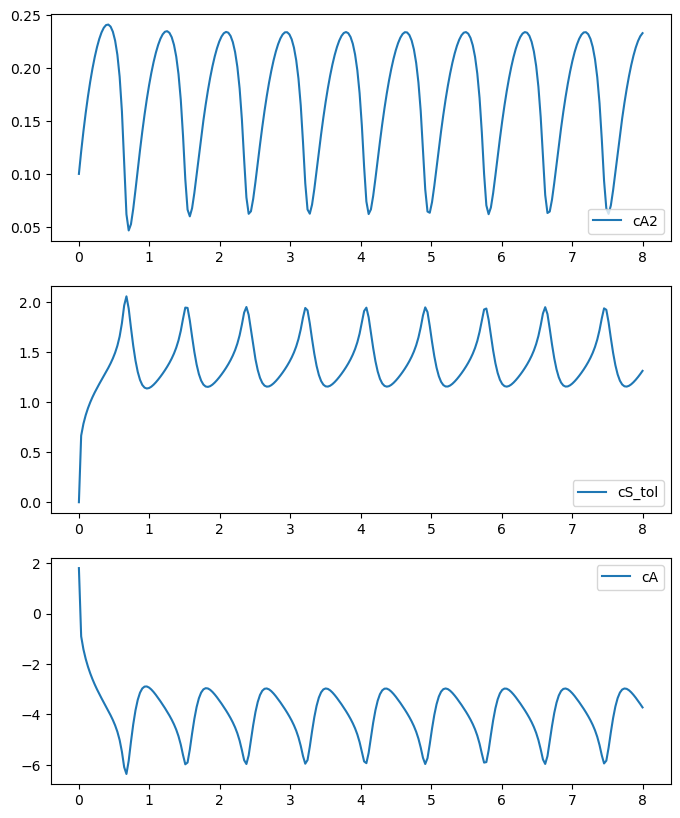

In [ ]:
model_test.plot(init_cA2, t=8)

In [ ]:
model_test.interactive_plot((0.1, 0), range=5)

4 parameters


interactive(children=(FloatSlider(value=24.30616411, description='alpha', max=29.30616411, min=19.30616411), F…

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Define function
def hill_function(x, m, K):
    return x**m / (K**m + x**m)

# Interactive function
def plot_hill(m, K):
    x = np.linspace(0, 10, 100)
    y = hill_function(x, m, K)

    fig, ax = plt.subplots()
    ax.plot(x, y, label=f'm={m}, K={K}')

# Create sliders
m_slider = widgets.FloatSlider(min=0.1, max=5, step=0.1, value=2, description="m")
K_slider = widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1, description="K")

# Display interactive plot
widgets.interactive(plot_hill, m=m_slider, K=K_slider)


interactive(children=(FloatSlider(value=2.0, description='m', max=5.0, min=0.1), FloatSlider(value=1.0, descri…